In [3]:
# Импорт библиотек
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [6]:
def load_data():
    """
    Загружает обучающие данные, метаданные и категории из файлов.
    
    Returns:
        data (DataFrame): Датафрейм с обучающими данными о категориях.
        metadata (DataFrame): Датафрейм с метаданными о тегах IAB.
        categories (dict): Словарь с данными о категориях, загруженный из YAML-файла.
    """
    
    # Загрузка обучающих данных из CSV-файла и удаление строк с отсутствующими значениями
    data = pd.read_csv("~/baseline/train_data_categories.csv").dropna()
    
    # Загрузка метаданных из другого CSV-файла, исключая последнюю строку
    metadata = pd.read_csv("~/baseline/IAB_tags.csv").iloc[:-1]
    
    # Загрузка категорий из YAML-файла
    with open("/root/NaruTagAI_ML/category.yaml", 'r') as stream:
        categories = yaml.safe_load(stream)
    
    # Вывод количества загруженных видео
    print(f"{data.shape[0]} видео")

    return data, metadata, categories

# Использование функции загрузки и вывода
data, metadata, categories = load_data()


1048 видео


# Preprocess

In [9]:
def categories_extraction(tags, level=0):
    """
    Функция извлекает категории из строки тегов на основе указанного уровня.
    
    Параметры:
        tags (str): Строка тегов, разделенная запятыми и двоеточиями.
        level (int): Уровень категории для извлечения (0, 1 или 2).
    
    Возвращает:
        list: Список категорий для указанного уровня. 
        Если категория отсутствует, возвращает None.
    """
    
    # Разделение тегов по запятой
    categories = [cat.strip().split(':') for cat in tags.split(',')]
    
    # Извлечение категории по заданному уровню
    levels = [cat[level].strip() if len(cat) > level else None for cat in categories]
    
    return levels

# Применение функции и создание новых столбцов с уровнями категорий
data['lvl0'] = data['tags'].apply(categories_extraction, level=0)
data['lvl1'] = data['tags'].apply(categories_extraction, level=1)
data['lvl2'] = data['tags'].apply(categories_extraction, level=2)

# Подсчет количества категорий на каждом уровне
data['count_lvl0'] = data['lvl0'].apply(lambda x: sum(cat is not None for cat in x))
data['count_lvl1'] = data['lvl1'].apply(lambda x: sum(cat is not None for cat in x))
data['count_lvl2'] = data['lvl2'].apply(lambda x: sum(cat is not None for cat in x))


# Количество категорий для видео

/tmp/ipykernel_196787/140783081.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='count_lvl0', data=data, ax=axs[0], palette='Blues')
/tmp/ipykernel_196787/140783081.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='count_lvl1', data=data, ax=axs[1], palette='Greens')
/tmp/ipykernel_196787/140783081.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='count_lvl2', data=data, ax=axs[2], palette='Oranges')


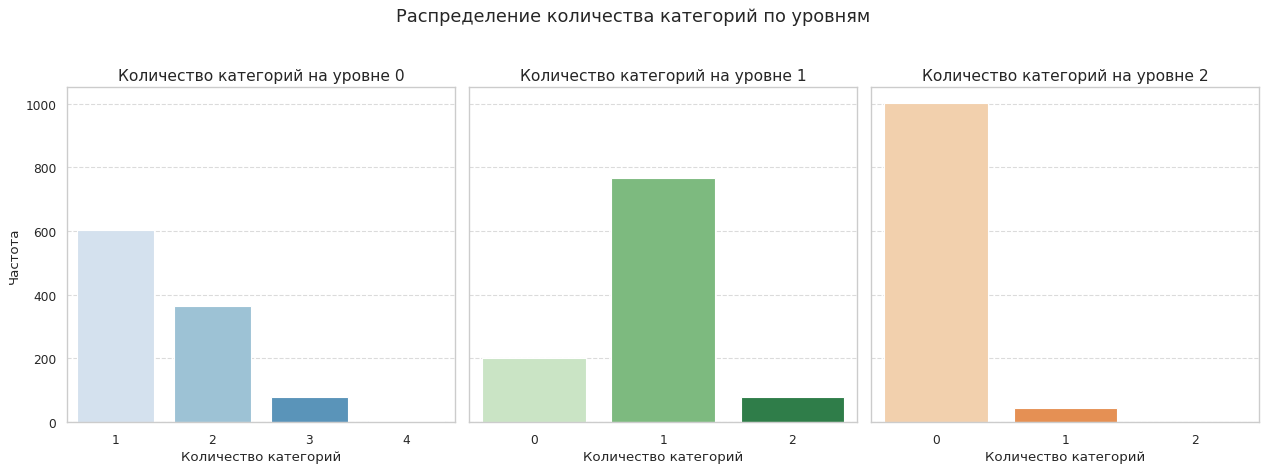

In [10]:
# Настройка внешнего вида графиков
sns.set(style="whitegrid")

# Создание фигуры с подграфиками
fig, axs = plt.subplots(1, 3, figsize=(16, 6), dpi=80, sharey=True)

# Заголовок для всей фигуры
fig.suptitle('Распределение количества категорий по уровням', fontsize=16)

# Построение графика для уровня 0
sns.countplot(x='count_lvl0', data=data, ax=axs[0], palette='Blues')
axs[0].set_title('Количество категорий на уровне 0', fontsize=14)
axs[0].set_xlabel('Количество категорий', fontsize=12)
axs[0].set_ylabel('Частота', fontsize=12)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)  # Добавление сетки

# Построение графика для уровня 1
sns.countplot(x='count_lvl1', data=data, ax=axs[1], palette='Greens')
axs[1].set_title('Количество категорий на уровне 1', fontsize=14)
axs[1].set_xlabel('Количество категорий', fontsize=12)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)  # Добавление сетки

# Построение графика для уровня 2
sns.countplot(x='count_lvl2', data=data, ax=axs[2], palette='Oranges')
axs[2].set_title('Количество категорий на уровне 2', fontsize=14)
axs[2].set_xlabel('Количество категорий', fontsize=12)
axs[2].grid(axis='y', linestyle='--', alpha=0.7)  # Добавление сетки

# Отображение графиков
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Подгонка расположения графиков
plt.show()


## Create dataset

In [11]:
def categories_extraction(x):
    """
    Извлечение уникальных категорий из строки тегов.

    Параметры:
    x (str): Строка тегов, разделенных запятыми.

    Возвращает:
    str: Строка с уникальными категориями, разделенными запятыми.
    """
    # Разделение строки на категории
    x = x.split(',')
    # Извлечение первой части каждой категории (до символа ':' или табуляции) и удаление пробелов
    x = [re.split(r'[:\t]', cat)[0].strip() for cat in x]
    # Удаление дубликатов и объединение категорий в строку
    x = ', '.join(set(x))
    return x


def fetch_tags(tag):
    """
    Извлечение тегов из строки.

    Параметры:
    tag (str): Строка тегов, разделенных символом '%'.

    Возвращает:
    set: Множество уникальных тегов.
    """
    tags = set()
    # Разделение строки на подкатегории
    tags_split = re.split(r'[%]', tag)
    # Добавление каждой подкатегории в множество тегов
    for subcat in tags_split:
        tags.add(subcat.strip())
    return tags


def tags_extraction(x):
    """
    Извлечение всех тегов из строки, учитывая вложенные категории.

    Параметры:
    x (str): Строка тегов, разделенных запятыми.

    Возвращает:
    str: Строка с уникальными тегами, разделенными запятыми.
    """
    # Разделение строки на категории
    x = x.split(',')

    levels = set()
    # Обработка каждой категории
    for cat in x:
        # Разделение категории на части
        cat = re.split(r'[:\t]', cat)
        # Если в категории более двух частей, извлекаем теги из второй и третьей части
        if len(cat) > 2:
            levels |= fetch_tags(cat[1])
            levels |= fetch_tags(cat[2])

        # Если в категории есть вторая часть, извлекаем теги из нее
        if len(cat) > 1:
            levels |= fetch_tags(cat[1])
    
    return ', '.join(levels)

In [12]:
def process_video_metadata(input_file: str, output_file_1: str, output_file_2: str) -> pd.DataFrame:
    """
    Обрабатывает метаданные видео, извлекая категории и теги, 
    и сохраняет результаты в новом CSV файле.

    Параметры:
    input_file (str): Путь к исходному CSV файлу с данными видео.
    output_file_1 (str): Путь к файлу, в который будет сохранён первый вариант метаданных.
    output_file_2 (str): Путь к файлу, в который будет сохранён второй вариант метаданных.

    Возвращает:
    pd.DataFrame: Обработанный DataFrame с метаданными видео.
    """
    # Считывание данных из файла и удаление строк с пропущенными значениями
    new_data = pd.read_csv(input_file).dropna()

    # Извлечение категорий и новых тегов
    new_data['categories'] = new_data.tags.apply(categories_extraction)
    new_data['new_tags'] = new_data.tags.apply(tags_extraction)

    # Удаление исходного столбца с тегами
    new_data = new_data.drop('tags', axis=1)

    # Переименование столбцов для удобства
    new_data = new_data.rename(columns={"new_tags": "tag", "categories": "category"})

    # Упорядочивание столбцов
    new_data = new_data[['video_id', 'category', 'tag', 'title', 'description']]

    # Сохранение обработанных данных в новые CSV файлы
    new_data.to_csv(output_file_1, index=False)
    new_data.to_csv(output_file_2, index=False)

    # Возврат обработанного DataFrame
    return new_data


# Пример использования функции
input_file_path = "/root/baseline/train_data_categories.csv"
output_file_path_1 = "~/NaRuTagAIback/data/metadata_rutube.csv" ####Исправить надо хз где это теперь
output_file_path_2 = "/mnt/nfs/data/metadata_rutube.csv"        #######Аналогично

# Вызов функции и получение обработанных данных
processed_data = process_video_metadata(input_file_path, output_file_path_1, output_file_path_2)

# Вывод первых нескольких строк обработанного DataFrame для проверки
print(processed_data.head())

OSError: Cannot save file into a non-existent directory: '/root/NaRuTagAIback/data'

# Our tags

In [15]:
def extract_and_save_tags(metadata_file: str, output_file_1: str, output_file_2: str, processed_data: ) -> None:
    """
    Извлекает уникальные теги из метаданных видео и сохраняет их в два разных CSV файла.

    Параметры:
    metadata_file (str): Путь к исходному CSV файлу с метаданными видео.
    output_file_1 (str): Путь к файлу, в который будут сохранены уникальные теги.
    output_file_2 (str): Путь к файлу, в который будут сохранены все уникальные теги из новых данных.

    Возвращает:
    None
    """
    # Считывание данных из файла метаданных
    our_data = pd.read_csv(metadata_file)

    # Сохранение уникальных тегов из метаданных в первый файл
    with open(output_file_1, 'w') as f:
        for tag in our_data.tag.unique():
            print(tag, end='\n', file=f)

    # Извлечение всех уникальных тегов из новых данных
    all_tags = set()
    for tags in processed_data.tag.apply(lambda x: x.split(', ')).values:
        if tags[0] != '':
            all_tags |= set(tags)

    # Сохранение всех уникальных тегов во второй файл
    with open(output_file_2, 'w') as f:
        for tag in sorted(all_tags):
            print(tag, end='\n', file=f)

    print(f"Теги успешно сохранены в '{output_file_1}' и '{output_file_2}'.")


# Пример использования функции
metadata_file_path = '/root/EDA/metadata.csv'
output_file_path_1 = 'our_tags.csv'
output_file_path_2 = 'rutube_tags.csv'

# Вызов функции для извлечения и сохранения тегов
extract_and_save_tags(metadata_file_path, output_file_path_1, output_file_path_2)

NameError: name 'new_data' is not defined

In [16]:
processed_data[processed_data.category.apply(lambda x: 'покупки' in x.lower())]

NameError: name 'processed_data' is not defined

In [151]:
all_tags = []
for i in processed_data.tag.values:
    i = i.split(', ')
    all_tags.extend(i)

In [152]:
all_tags = np.array(all_tags)
any(['природа' in x for x in all_tags])

False

In [157]:
processed_data[processed_data.category=='Хобби и интересы'].tag.unique()

array(['Декоративно-прикладное искусство', '', 'Мастер-классы',
       'Паранормальные явления', 'Музыкальные инструменты',
       'Создание контента'], dtype=object)